In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import datetime
import json
import tensorflow as tf
from tqdm.keras import TqdmCallback

sns.set_theme()

try: # are we in Colab?
    import google.colab
    COMPUTE_ENV = 'colab'
    print('Running in Colab.')
    OUTPUT_DIR = "./output/"
    #google.colab.drive.mount('/content/gdrive')
    #os.chdir('/content/gdrive/My Drive/projects/xxx')
    !git clone https://github.com/FriedChips/dl_basics.git
    sys.path.insert(0,'/content/dl_basics')
except: # if not...
    if "kaggle" in os.environ["PWD"]: # are we in Kaggle?
        COMPUTE_ENV = 'kaggle'
        print('Running in Kaggle.')
        OUTPUT_DIR = "./"
    else: # we're local
        COMPUTE_ENV = os.uname()[1]
        print(f"Running locally on {COMPUTE_ENV}.")
        sys.path.insert(0,'./../')
        OUTPUT_DIR = "../output/"

for gpu in tf.config.list_physical_devices("GPU"):
    print(f"Found GPU: {tf.config.experimental.get_device_details(gpu)['device_name']}.")

2023-04-13 08:42:01.008127: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Running locally on beta.


In [2]:
from data_gen.synth_sequences import SynthNNumbers
import models
import utils

In [3]:
P = {}

P["SynthNNumbers"] = {
    "batch_size" : 64,
    "n" : 2,
    "operation" : "multiply",
    "limit" : 1,
    "distribution" : "uniform",
    "seed" : 42,
}

data_gen = SynthNNumbers(**P["SynthNNumbers"])
x, y = data_gen.__getitem__(1)
print(x.shape, x.dtype, y.shape, y.dtype)
print(x[0], y[0])

(64, 2) float32 (64,) float32
[ 0.5479121  -0.12224312] -0.066978484


In [4]:
# init new run

'''
P["model_name"] = "gru_01"
P["model_build_params"] = {
    "gru_units" : 32,
    "num_outputs" : 1,
    "input_shape" : (P["SynthMathData"]["seq_len"], 2),
    "num_hidden_gru" : 3,
    "use_embedding" : False,
    "return_final_hidden" : True,
}

model = tf.keras.Sequential([
    tf.keras.Input(shape=(P["SynthNNumbers"]["n"],)),
    utils.Quadratic(1)
])

'''

P["model_name"] = "mlp_01"
P["model_build_params"] = {
    "input_shape" : (P["SynthNNumbers"]["n"],),
    "layer_units" : [ 128, 1 ],
    "activations" : [ "gelu", "linear" ],
    "use_bias" : False,
}

model = eval("models." + P["model_name"])(**P["model_build_params"])

model.compile(
    loss = "mse",
    #optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2),
    optimizer = tf.keras.optimizers.experimental.AdamW(learning_rate=1e-2, weight_decay=1),
    metrics = [ "mae" ]
)

model.summary()

P["run_dir"] = model.name + datetime.datetime.now().strftime('-%y%m%d-%H%M%S')
print("Run dir :", P["run_dir"])

run = utils.TrainingRun()

Model: "mlp_01"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 2)]               0         
                                                                 
 dense_0 (Dense)             (None, 128)               256       
                                                                 
 tf.nn.gelu (TFOpLambda)     (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 128       
                                                                 
Total params: 384
Trainable params: 384
Non-trainable params: 0
_________________________________________________________________
Run dir : mlp_01-230413-084301


2023-04-13 08:43:00.896715: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-13 08:43:00.900402: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [5]:
NUM_EPOCHS = 1024 * 1
#lr_sched = utils.Schedule_ExpCos_Segments([[-3,-3, NUM_EPOCHS]])

history = model.fit(
    data_gen,
    epochs = NUM_EPOCHS,
    callbacks=[
        TqdmCallback(verbose=0),
        #tf.keras.callbacks.LearningRateScheduler(lr_sched.scheduler),
    ],        
    verbose=0)

run.update_history(history)

0epoch [00:00, ?epoch/s]

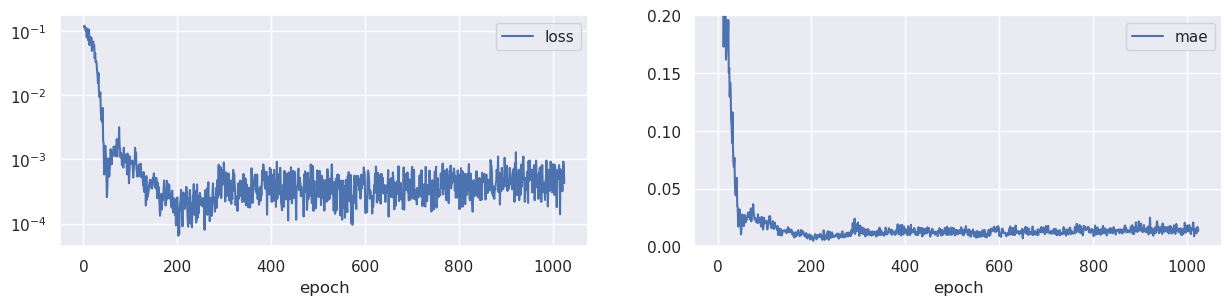

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(15,3))

sns.lineplot(data=run.history[["loss"]], ax=axs[0], dashes=False);
axs[0].set_yscale("log");

sns.lineplot(data=run.history[["mae"]], ax=axs[1], dashes=False);
axs[1].set_ylim(0,0.2);

#sns.lineplot(data=run.history[["lr"]], ax=axs[2], dashes=False);

In [75]:
#model.compile(
#    loss = "mse",
#    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5),
#    metrics = [ "mae" ]
#)

In [7]:
run.save_state(os.path.join(OUTPUT_DIR, P["run_dir"]), P, model)

2/2 [==============================] - 0s 6ms/step


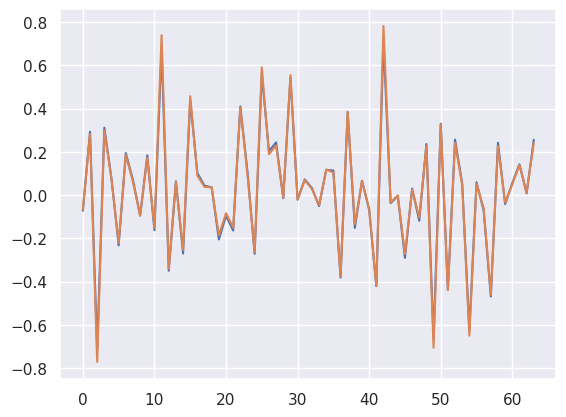

In [8]:
y_pred = model.predict(x)
plt.plot(y_pred)
plt.plot(y)

In [9]:
[ w.shape for w in model.get_weights() ]

[(2, 128), (128, 1)]

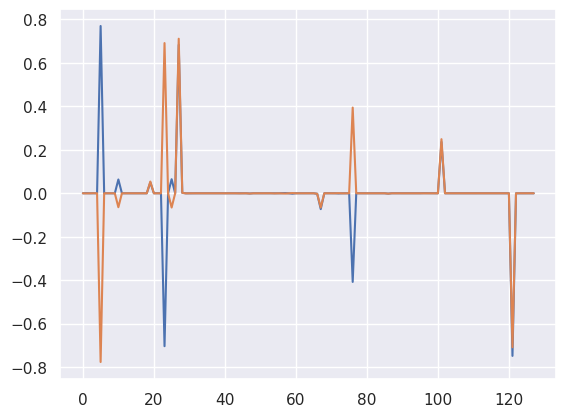

In [10]:
plt.plot(model.get_weights()[0].T);

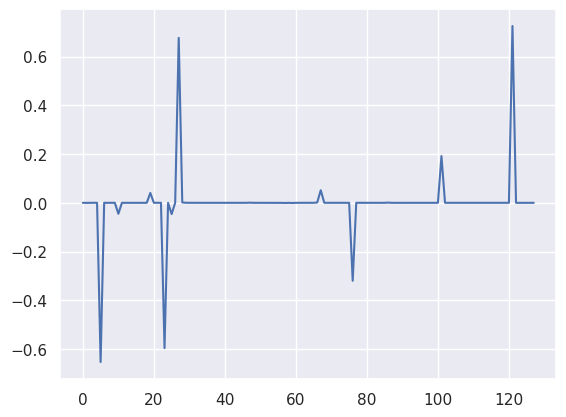

In [11]:
plt.plot(model.get_weights()[1]);

313/313 [==============================] - 1s 2ms/step


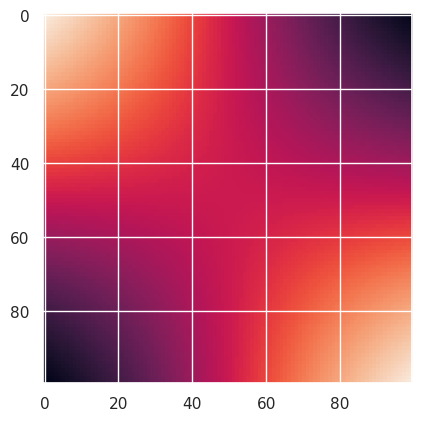

In [12]:
x_test = np.array([ [x1, x2] for x2 in np.linspace(-1,1,100) for x1 in np.linspace(-1,1,100) ])
y_test = np.prod(x_test, axis=-1)

y_pred = model.predict(x_test)

plt.imshow(y_pred.reshape(100,100));

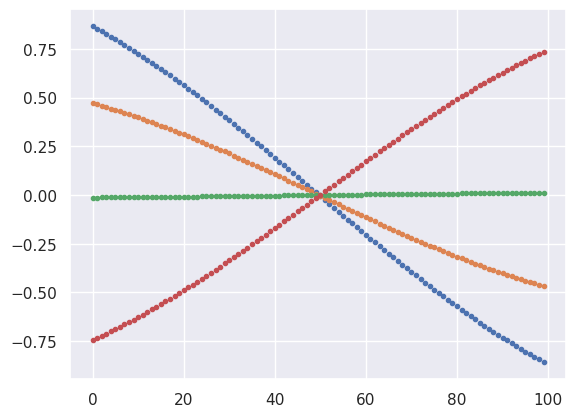

In [14]:
plt.plot(y_pred.reshape(100,100)[0], ".");
plt.plot(y_pred.reshape(100,100)[25], ".");
plt.plot(y_pred.reshape(100,100)[50], ".");
plt.plot(y_pred.reshape(100,100)[90], ".");